In [2]:
#importing libraries
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt

#file paths
AUDIO_DIR = "C:/Users/siona/Downloads/UrbanSound_Filtered/UrbanSound_Filtered/audio"
CSV_PATH = "C:/Users/siona/Downloads/UrbanSound_Filtered/UrbanSound_Filtered/filtered_metadata.csv"


In [3]:
#reading data
metadata = pd.read_csv(CSV_PATH)
print(metadata.head())

#checking classes
print(f"cclasses available: {metadata['class'].unique()}")


    slice_file_name    fsID  start       end  salience  fold  classID  \
0  100032-3-0-0.wav  100032    0.0  0.317551         1     5        3   
1  100652-3-0-0.wav  100652    0.0  4.000000         1     2        3   
2  100652-3-0-1.wav  100652    0.5  4.500000         1     2        3   
3  100652-3-0-2.wav  100652    1.0  5.000000         1     2        3   
4  100652-3-0-3.wav  100652    1.5  5.500000         1     2        3   

      class  
0  dog_bark  
1  dog_bark  
2  dog_bark  
3  dog_bark  
4  dog_bark  
cclasses available: ['dog_bark' 'street_music' 'drilling']


In [20]:
#feature extraction
def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=5.0, sr=None)  # fixed 5-sec clip
    
# pad or trim to 5 seconds
    target_length = sr * 5
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)))
    else:
        y = y[:target_length]

    # Temporal and spectral features
    zcr = librosa.feature.zero_crossing_rate(y).mean()
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    
    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = mfcc.mean(axis=1)
    
    # Chroma & Tonnetz
    chroma = librosa.feature.chroma_stft(y=y, sr=sr).mean(axis=1)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr).mean(axis=1)
    
    features = np.hstack([
        zcr, centroid, bandwidth, tempo,
        mfccs_mean, chroma[:2], tonnetz[:2]
    ])
    return features


In [21]:

features_list = []
labels = []

#extract features and labels
for i, row in metadata.iterrows():
    file_path = os.path.join(AUDIO_DIR, row['slice_file_name'])
    try:
        features = extract_features(file_path)
        features_list.append(features)
        labels.append(row['class'])
    except Exception as e:
        print(f"Error processing {row['slice_file_name']}: {e}")

X = np.array(features_list)
y = np.array(labels)

print(f"Feature matrix shape: {X.shape}")


c:\Users\siona\miniconda3\envs\myenv\lib\site-packages\librosa\feature\spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\Users\siona\miniconda3\envs\myenv\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Error processing 99179-9-0-12.wav: Wavelet basis with max frequency=4114.095914935585 would exceed the Nyquist frequency=4000.0. Try reducing the number of frequency bins.
Error processing 99179-9-0-17.wav: Wavelet basis with max frequency=4091.975908048242 would exceed the Nyquist frequency=4000.0. Try reducing the number of frequency bins.
Error processing 99179-9-0-19.wav: Wavelet basis with max frequency=4089.612972586811 would exceed the Nyquist frequency=4000.0. Try reducing the number of frequency bins.
Error processing 99179-9-0-38.wav: Wavelet basis with max frequency=4073.8949018250687 would exceed the Nyquist frequency=4000.0. Try reducing the number of frequency bins.
Error processing 99179-9-0-53.wav: Wavelet basis with max frequency=4069.191271329872 would exceed the Nyquist frequency=4000.0. Try reducing the number of frequency bins.
Error processing 99179-9-0-58.wav: Wavelet basis with max frequency=4091.975908048242 would exceed the Nyquist frequency=4000.0. Try reduci

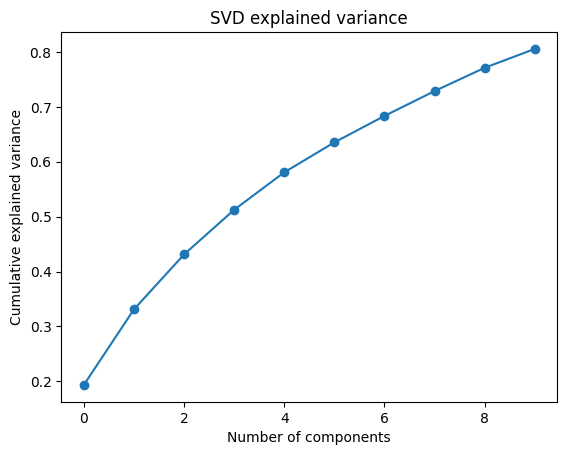

In [22]:
#standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#apply SVD
svd = TruncatedSVD(n_components=10, random_state=42)  # tune this!
X_svd = svd.fit_transform(X_scaled)

#plot
plt.plot(np.cumsum(svd.explained_variance_ratio_), marker='o')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("SVD explained variance")
plt.show()


In [23]:
#train
X_train, X_test, y_train, y_test = train_test_split(X_svd, y, test_size=0.2, random_state=42, stratify=y)

#random forest
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

#test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

    dog_bark       0.87      0.91      0.89       200
    drilling       0.90      0.82      0.86       200
street_music       0.90      0.93      0.92       198

    accuracy                           0.89       598
   macro avg       0.89      0.89      0.89       598
weighted avg       0.89      0.89      0.89       598

[[181  14   5]
 [ 19 165  16]
 [  9   4 185]]


In [24]:
#save
joblib.dump({
    "model": clf,
    "scaler": scaler,
    "svd": svd
}, "audio_classifier.pkl")

print("Model saved as audio_classifier.pkl")


Model saved as audio_classifier.pkl
